In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import numpy as np

from statsmodels.formula.api import ols
from scipy.stats import f, chi2

%matplotlib inline

In [2]:
import seaborn as sns
sns.set(color_codes=True)

# MOOC Econometrics
## Test Exercise 6

This test exercise uses data that are available in the data file `TestExer6`. 

In [3]:
euro = pd.read_csv('TestExer 6-CPI-round1.txt', sep='\t', index_col=False)
euro.head()

,YYYYMM,TREND,CPI_EUR,CPI_USA,LOGPEUR,LOGPUSA,DPEUR,DPUSA
0,2000M01,1,105.1,107.6,4.654912,4.678421,NaN,NaN
1,2000M02,2,105.4,108.3,4.657763,4.684905,0.002850,0.006485
2,2000M03,3,105.8,109.1,4.661551,4.692265,0.003788,0.007360
3,2000M04,4,105.9,109.2,4.662495,4.693181,0.000945,0.000916
4,2000M05,5,106.0,109.3,4.663439,4.694096,0.000944,0.000915


The question of interest is to model monthly
inflation in the Euro area and to investigate whether inflation in the United States of America has predictive power
for inflation in the Euro area. 

Monthly data on the consumer price index (CPI) for the Euro area and the USA are
available from January 2000 until December 2011. The data for January 2000 until December 2010 are used for
specification and estimation of models, and the data for 2011 are left out for forecast evaluation purposes.

In [4]:
euro['YEAR'] = euro.YYYYMM.str[0:4].astype(int)

train = euro.YEAR < 2011
test = ~train

**(a)** Make time series plots of

- $\text{CPI}$ of the Euro area and the USA, and 
- their logarithm $\log \text{CPI}$ and
- the two monthly inflation series $\text{DP} = \Delta \log \text{CPI}$. 

What conclusions do you draw from these plots?

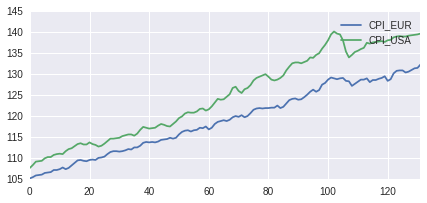

In [19]:
plt.figure(figsize=(7, 3))
euro[train].CPI_EUR.plot()
euro[train].CPI_USA.plot()
plt.legend()
plt.show()

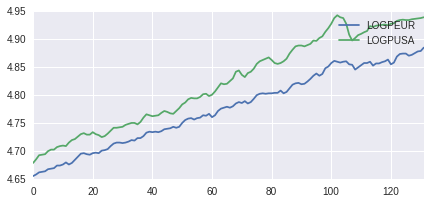

In [20]:
plt.figure(figsize=(7, 3))
euro[train].LOGPEUR.plot()
euro[train].LOGPUSA.plot()
plt.legend()
plt.show()

Both `EUR` and `USA` show positive upwards trend - so they are not stationary. 

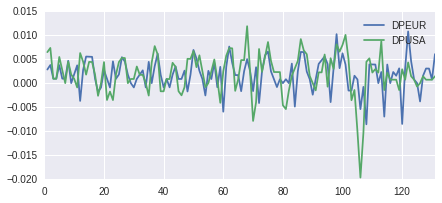

In [21]:
plt.figure(figsize=(7, 3))
euro[train].DPEUR.plot()
euro[train].DPUSA.plot()
plt.legend()
plt.show()

The differences look stationary, although variance seems higher towards the end of the series.

**(b)** Perform the Augmented Dickey-Fuller (ADF) test for the two $\log \text{CPI}$ series. 

In the ADF test equation, include:
- a constant ($α$), 
- a deterministic trend term ($β\, t$), 
- three lags of $\text{DP} = \Delta \log \text{CPI}$ and, 
- of course, the variable of interest $\log \text{CPI}_{t-1}$

Report the coefficient of $\log \text{CPI}_{t-1}$, its standard error and $t$-value, and draw your conclusion.

In [6]:
def summary(model, names):
    return pd.DataFrame(
             {'coeff': names,
              'value': model.params.round(4), 
              '$t$-value': model.tvalues.round(4),
              'SE': model.bse.round(4),
              '$p$-value': model.pvalues.round(4)},
             columns=['coeff', 'value', 'SE', '$t$-value', '$p$-value'])

First, apply it to EUR:

$$\text{DPEUR}_t = \alpha + \beta\, t + \gamma_1\, \text{DPEUR}_{t-1} + \gamma_2\, \text{DPEUR}_{t-2} + \\ \gamma_3\, \text{DPEUR}_{t-3} + \rho\, \text{LOGPEUR}_{t-1}$$

In [7]:
adf_eur = ols('DPEUR ~ TREND + DPEUR.shift(1) + DPEUR.shift(2) + '
                      'DPEUR.shift(3) + LOGPEUR.shift(1)', 
              data=euro[train]).fit()
summary(adf_eur, names=[r'$\alpha$', r'$\beta$', r'$\gamma_1$', 
                        r'$\gamma_2$', r'$\gamma_3$', r'$\rho$'])

,coeff,value,SE,$t$-value,$p$-value
Intercept,$\alpha$,0.5589,0.2267,2.4659,0.0151
TREND,$\beta$,0.0002,0.0001,2.3797,0.0189
DPEUR.shift(1),$\gamma_1$,0.1343,0.0917,1.4648,0.1455
DPEUR.shift(2),$\gamma_2$,-0.0410,0.0908,-0.4521,0.6520
DPEUR.shift(3),$\gamma_3$,-0.1270,0.0913,-1.3921,0.1664
LOGPEUR.shift(1),$\rho$,-0.1195,0.0487,-2.4548,0.0155


- The last row if the table reports the coefficient of $\log \text{CPIEUR}_{t-1}$, its standard error and $t$-value. 
- Critical value of the ADF test with trend included is -3.5, which is less than $t_\rho = -2.82$, so we canntot reject the $H_0$ that $\log \text{CPIEUR}$ is non-stationary.

We can repeat the same analysis with the `adfuller` function from StatsModels:

In [8]:
# regression='ct' means to inslude constant and the trend
t, p = ts.adfuller(euro.LOGPEUR[train], maxlag=3, autolag=None, 
                   regression='ct')[:2]
print 't-value = %0.4f (p-value = %0.4f)' % (t, p)

t-value = -2.4547 (p-value = 0.3510)


Next, apply it to USA:

$$\text{DPUSA}_t = \alpha + \beta\, t + \gamma_1\, \text{DPUSA}_{t-1} + \gamma_2\, \text{DPUSA}_{t-2} + \\ \gamma_3\, \text{DPUSA}_{t-3} + \rho\, \text{LOGPUSA}_{t-1}$$

In [9]:
t, p = ts.adfuller(euro.LOGPUSA[train], maxlag=3, autolag=None, 
                   regression='ct')[:2]
print 't-value = %0.4f (p-value = %0.4f)' % (t, p)

t-value = -2.4031 (p-value = 0.3780)


Again, we cannot reject the hypothesis that  $\log \text{CPIUSA}$ is non-stationary.

**(c)** As the two series of $\log \text{CPI}$ are not cointegrated (you need not check this), we continue by modelling the
monthly inflation series $\text{DPEUR} = \Delta \log \text{CPIEUR}$ for the Euro area. 

Determine:

- the sample autocorrelations and 
- the sample partial autocorrelations of this series to motivate the use of the following AR model: 

$$\text{DPEUR}_t = α + β_1\, \text{DPEUR}_{t-6} + β_2\, \text{DPEUR}_{t-12} + ε_t .$$

Estimate the parameters of this model (sample Jan 2000 - Dec 2010).

- autocorrelation:

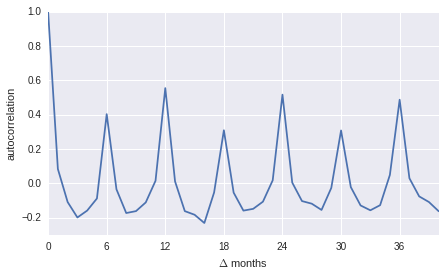

In [10]:
autocorr = ts.acf(euro[train].DPEUR.dropna())

plt.figure(figsize=(7, 4))
plt.plot(autocorr)
plt.xticks(range(0, 40, 6))
plt.xlabel('$\Delta$ months')
plt.ylim([-0.3, 1])
plt.ylabel('autocorrelation')
plt.show()

We see that the autocorrelation is higher for multipliers of 6

- partial autocorrelation

In [11]:
model_c = ols('DPEUR ~ DPEUR.shift(6) + DPEUR.shift(12)', data=euro[train]).fit()
summary(model_c, names=[r'$\alpha$', r'$\beta_1$', r'$\beta_2$'])

,coeff,value,SE,$t$-value,$p$-value
Intercept,$\alpha$,0.0004,0.0003,1.3650,0.1749
DPEUR.shift(6),$\beta_1$,0.1887,0.0773,2.4421,0.0161
DPEUR.shift(12),$\beta_2$,0.5980,0.0836,7.1568,0.0000


**(d)** 

1. Extend the `AR` model of part **(c)** by adding lagged values of monthly inflation in the USA at lags 1, 6,
and 12. Check that the coefficient at lag 6 is not significant, and 
3. Estimate the `ADL` model 

$$\text{DPEUR}_t = α + β_1\, \text{DPEUR}_{t-6} + β_2\, \text{DPEUR}_{t-12} + γ_1\, \text{DPUSA}_{t-1} + \\ γ_2\, \text{DPUSA}_{t-12} + ε_t$$ (sample Jan 2000 - Dec 2010).

**(d1)** Extend the `AR` model of part **(c)** by adding lagged values of monthly inflation in the USA at lags 1, 6,
and 12.

In [12]:
model_d1 = ols('DPEUR ~ DPEUR.shift(6) + DPEUR.shift(12) + DPUSA.shift(1) + '
                       'DPUSA.shift(6) + DPUSA.shift(12)', 
               data=euro[train]).fit()
summary(model_d1, names=[r'$\alpha$', r'$\beta_1$', r'$\beta_2$', 
                         r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$'])

,coeff,value,SE,$t$-value,$p$-value
Intercept,$\alpha$,0.0004,0.0003,1.5445,0.1253
DPEUR.shift(6),$\beta_1$,0.2030,0.0786,2.5841,0.0110
DPEUR.shift(12),$\beta_2$,0.6367,0.0875,7.2790,0.0000
DPUSA.shift(1),$\gamma_1$,0.2264,0.0511,4.4286,0.0000
DPUSA.shift(6),$\gamma_2$,-0.0561,0.0548,-1.0236,0.3082
DPUSA.shift(12),$\gamma_3$,-0.2300,0.0542,-4.2467,0.0000


Indeed, we see that $p$-value of $\gamma_2$ suggests that the coefficient for $\text{DPUSA}_{t-6}$ is not significant.

**(d2)** Estimate the `ADL` model 

$$\text{DPEUR}_t = α + β_1\, \text{DPEUR}_{t-6} + β_2\, \text{DPEUR}_{t-12} + γ_1\, \text{DPUSA}_{t-1} + \\ γ_2\, \text{DPUSA}_{t-12} + ε_t$$ (sample Jan 2000 - Dec 2010).

In [13]:
model_d2 = ols('DPEUR ~ DPEUR.shift(6) + DPEUR.shift(12) + DPUSA.shift(1) + '
                       'DPUSA.shift(12)', 
               data=euro[train]).fit()
summary(model_d2, names=[r'$\alpha$', r'$\beta_1$', r'$\beta_2$', 
                         r'$\gamma_1$', r'$\gamma_2$'])

,coeff,value,SE,$t$-value,$p$-value
Intercept,$\alpha$,0.0003,0.0003,1.2673,0.2076
DPEUR.shift(6),$\beta_1$,0.1687,0.0711,2.3738,0.0193
DPEUR.shift(12),$\beta_2$,0.6552,0.0856,7.6513,0.0000
DPUSA.shift(1),$\gamma_1$,0.2326,0.0508,4.5817,0.0000
DPUSA.shift(12),$\gamma_2$,-0.2265,0.0541,-4.1888,0.0001


**(e)** Use the models of parts **(c)** and **(d)** to make two series of 12 monthly inflation forecasts for 2011. At each month, you should use the data that are then available, for example, to forecast inflation for September 2011
you can use the data up to and including August 2011. However, do not re-estimate the model and use the
coefficients as obtained in parts **(c)** and **(d)**. For each of the two forecast series, compute the values of the root mean squared error (RMSE), mean absolute error (MAE), and the sum of the forecast errors (SUM). Finally,
give your interpretation of the outcomes.

In [14]:
X = sm.add_constant(np.column_stack([euro.DPEUR.shift(6), euro.DPEUR.shift(12)]))
c_pred = model_c.predict(X[np.where(test)], transform=False)

In [15]:
X = sm.add_constant(np.column_stack([euro.DPEUR.shift(6), euro.DPEUR.shift(12),
                                     euro.DPUSA.shift(1), euro.DPUSA.shift(12)]))
d_pred = model_d2.predict(X[np.where(test)], transform=False)

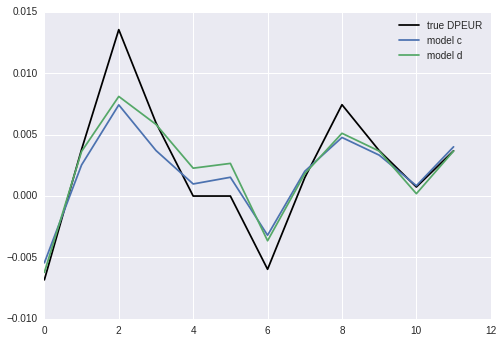

In [16]:
plt.plot(euro[test].DPEUR, color='black', label='true DPEUR')
plt.plot(c_pred, label='model c')
plt.plot(d_pred, label='model d')
plt.legend()
plt.show()

In general models appear to perform quite well: we see that they correctly predict the direction of the change, and they both are quite close to the true value

In [17]:
def rmse(real, predicted):
    mse = np.mean((real - predicted) ** 2)
    return np.sqrt(mse)

def mae(real, predicted):
    return np.abs(real - predicted).mean()

def sum_fe(real, predicted):
    return np.sum(real - predicted)

def all_metrics(real, predicted):
    return rmse(real, predicted), mae(real, predicted), sum_fe(real, predicted)

In [18]:
real = euro[test].DPEUR

df = pd.DataFrame({'model c': all_metrics(real, c_pred),
                   'model d': all_metrics(real, d_pred)},
                  columns=['model c', 'model d'])
df.index = ['RMSE', 'MAE', 'SUM']
df

,model c,model d
RMSE,0.002324,0.002111
MAE,0.001693,0.001404
SUM,0.005065,0.000478


Model from **(d)** performs better in terms of **RMSE** and **MAE**